# ROB 498: Robot Learning for Planning and Control
# Assignment 5: Learning Latent Space Dynamics

## Colab Setup

In [1]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a ROB498 folder and put all the files under HW5 folder, then 'ROB498/HW5'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ROB498_HW/HW5'


### Setup Code 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

files = os.listdir(GOOGLE_DRIVE_PATH)
expected_files = [ 'ROB498_hw5.ipynb', 'learning_latent_dynamics.py', 'panda_pushing_env.py', 'visualizers.py', 'mppi.py', 'utils.py', 'pushing_image_data.npy', 'pushing_image_validation_data.npy']

sys.path.append(GOOGLE_DRIVE_PATH)

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
    if expected_file not in files:
        print(f'Required file {expected_file} not found!')
        all_found = False
if all_found:
    print('All required files are found :)')

All required files are found :)


In [5]:
# Install missing required packages 
# Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 MB 11.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

## Assignment Introduction

Due 4/12 at 11:59pm

**Rules**:

1. All homework must be done individually, but you are encouraged to post questions on Piazza

2. No late homework will be accepted (unless you use your late-day tokens)

3. Submit your code on [autograder.io](http://autograder.io/)

4. Remember that copying-and-pasting code from other sources is not allowed

5. The use of additional package imports beyound the packages we provide is not allowed. The autograder will not grade your code if you use additional packages.

**Instructions**
- Each problem will give you a file with some template code, and you need to fill in the
rest.
- We use the autograder, so if you’re ever wondering “will I get full points for
this?” just upload your code in the autograder to check. There is no limit to how
many times you can upload to autograder.
- The autograder may test your problem with multiple different inputs to make sure it is correct.
- The autograder will only show you if you got it right/wrong, so if you don’t get full points, try to test with some other inputs.

# Planar Pushing Learning From Images (100 points)

In this assignment we are again considering the planar pushing environment you have seen in HW3 and HW4. 

However, for this homework, we we will learn the dynamics directly from images. 

### State Space and Action Space

For the planar pushing task, we use the same action space as in HW3. The following image show the robot action space. 

![Action Space](https://drive.google.com/uc?export=view&id=1sFyNOAj-RmNbwk_Ww8VxmmkCaW4LpVZj)

Each action $\mathbf u = \begin{bmatrix} p & \phi & \ell\end{bmatrix}^\top\in \mathbb R^3$ is composed by:
* $p \in [-1,1]$: pushing location along the lower block edge.
* $\phi \in [-\frac{\pi}{2},\frac{\pi}{2}]$ pushing angle.
* $\ell\in [0,1]$ pushing length as a fraction of the maximum pushing length. The maximum pushing length is is 0.1 m

However, the state space is now a $32 \times 32 $ image from an overhead camera.

### Gym Environments

Our planar pushing task has been wrapped into a `gym` environment. You can find more information about the gym environments [here](https://gymnasium.farama.org/api/env/).

As a gym enviroment, our pushing enviroment has the following useful methods:

* `step`: Given an action vector, it performs the action in the simulator and returns 
    1. `state`: The resulting state, i.e. $x_{t+1}$. This will be an image.
    2. `reward`: Not used here (useful for Reinforcement Learning tasks).
    3. `done`: Boolean. In our case the simulation is done (`done=True`) if the robot has reached the goal location or if the block has left the bounds of the workspace.
    4. `info`: Dictionary containing additional data. Not used here.
        Example:
        ```python
        state, reward, done, info = env.step(action_i)
        ```
* `reset`: Resets the simulation to the initial state. It returns the inital state after reset. You can optionally reset the block to a known start pose.
    Example:
    ```python
        state = env.reset(object_pose=start_pose)
    ```


Moreover, our pushing environment has the following attributes:
* `env.action_space`: Represents the action space, following the described parametrization above.
* `env.observation_space`: Represents the state space. In this case this will be the space of valid $32 \times 32$ images. 
    * If `grayscale=True`, then observation space size is $(32, 32, 1)$
    * If `grayscale=False`, then observation space size is $(32, 32, 3)$
* `env.object_pose_space`: Represents valid object poses.
These are `gym.spaces` and therefore you can sample them using `.sample()`.
    Example:
    ```python
    action_i = env.action_space.sample()
    ```
    This produces actions uniformly sampled from the action space. You can find more info about gym spaces [here](https://gymnasium.farama.org/api/spaces/).


In [7]:
# Added by leekt
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.8/432.8 kB 7.9 MB/s eta 0:00:00


In [8]:
from panda_pushing_env import PandaImageSpacePushingEnv
from visualizers import GIFVisualizer, NotebookVisualizer

from learning_latent_dynamics import *
from utils import *

You can run the below block to see the environment in action, and the corresponding image observations

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


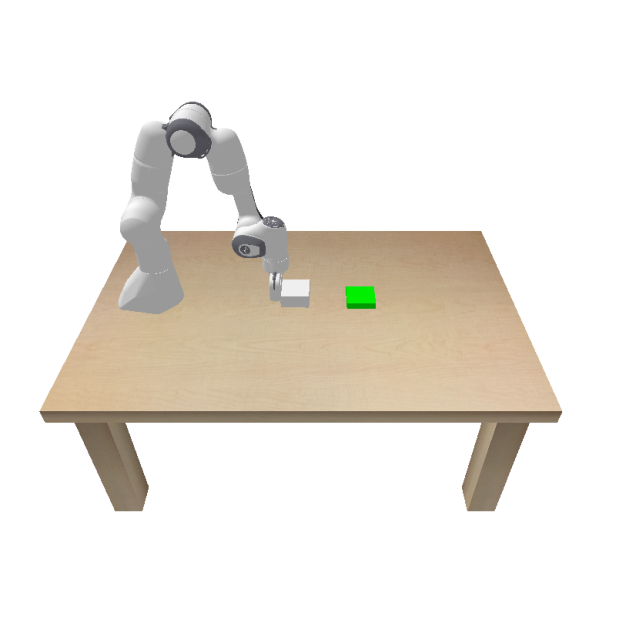

/usr/local/lib/python3.9/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
100%|██████████| 3/3 [00:53<00:00, 17.94s/it]


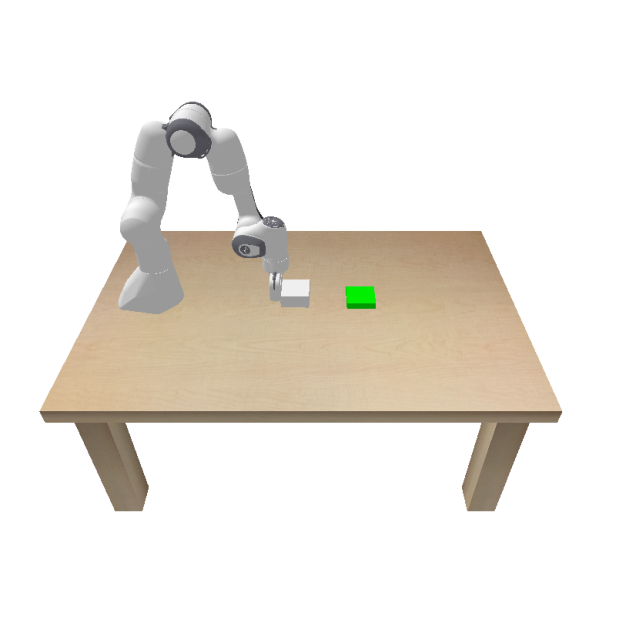

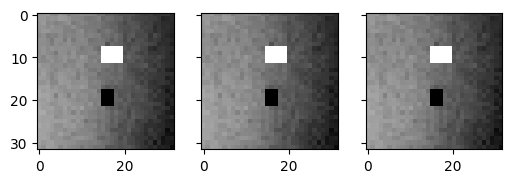

In [9]:
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment
env = PandaImageSpacePushingEnv(visualizer=visualizer, 
                                render_non_push_motions=True,  
                                camera_heigh=800, 
                                camera_width=800,
                                grayscale=True,
                                done_at_goal=False)
env.reset()
# Perform a sequence of 3 random actions:
states = []
for i in tqdm(range(3)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    states.append(state)
    if done:
        break
    
view_states(states)

plt.close(fig)

As in the previous homeworks, we can turn off rendering in the notebook which will increase the simulation speed. The speed-up will not be as significant as in the previous homeworks, since the simulator still needs to render the camera images for the image observations.  

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


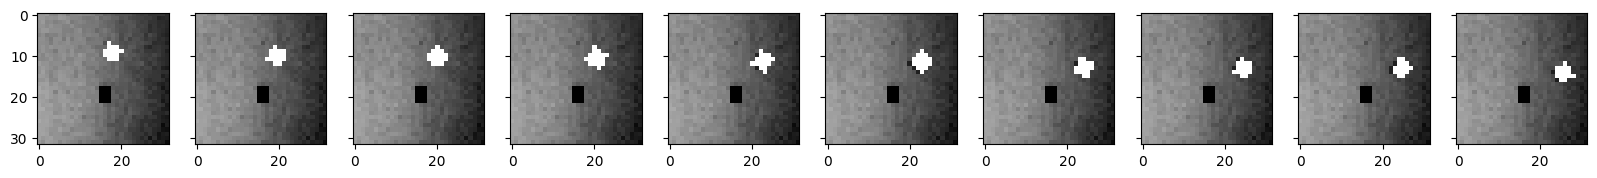

State shape: (32, 32, 1)  (width, height, num_channels)


In [10]:
# Simulate pushing without rendering - this should take about 5s.
visualizer = None # No redering

env = PandaImageSpacePushingEnv(visualizer=visualizer, grayscale=True)
env.reset()


states = []
pbar =  tqdm(range(10)) # We will perform 100 pushes.

for i in pbar:
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    states.append(state)
    if done:
        env.reset()
        
view_states(states)

print(f'State shape: {states[0].shape}  (width, height, num_channels)')

# 1 - Collect Data (10 points):
Given the environment, the first step is to collect data. In this first section, you will have to collect data. Since the data collection requires rendering images, generating a decent size dataset may take some time. To avoid unnecessary waiting time, we require you to just collect a small subset of data. The data you collected will be saved into `collected_data.npy` which you will have to submit to *Autograder*. To train the dynamics model of the pushing task, you will use the data we have collected for you which can be found in `pushing_image_data.npy`.

**TODO:**

* Implement `collect_data_random_trajectory` in `learning_latent_dynamics.py` which collects data trajectories. The actions should be uniformly random sampled within the action space limits.
* Your method should randomly initialize the object start pose.
* Your method should use the `done` output of `env.step` to ensure that the block pose is valid for the entirety of all trajectories. 


**GRADING**: For grading you will also have to submit the saved collected data file `collected_data.npy`. We will check that the collected data is in the required format. Note that for training a good model, data quality is key. Your collected data should be diverse to train an effective model of pushing dynamics.

100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


(32, 32, 1)


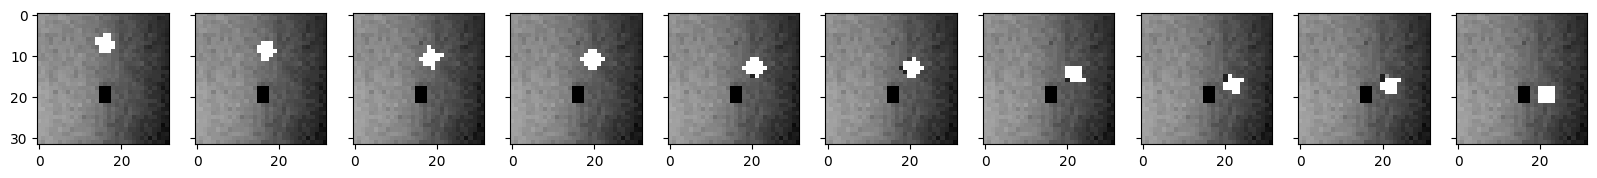

State shape: (32, 32, 1)  (width, height, num_channels)


In [11]:
# Simulate pushing without rendering - this should take about 5s.
visualizer = None # No redering

env = PandaImageSpacePushingEnv(visualizer=visualizer, grayscale=True)
env.reset()


states = []
pbar =  tqdm(range(10)) # We will perform 100 pushes.

for i in pbar:
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    states.append(state)
    if done:
        env.reset()
    
print(states[0].shape)
view_states(states)

print(f'State shape: {states[0].shape}  (width, height, num_channels)')

In [12]:
# # Collect data (it may take some time)
# from learning_latent_dynamics import collect_data_random_trajectory

# # Data collection parameters
# N = 15 # Number of trajectories to be collected
# T = 10 # Trajectory length

# grayscale = True

# # Initialize the environment and collect data
# env = PandaImageSpacePushingEnv(grayscale=grayscale, done_at_goal=False)
# env.reset()
# collected_data = collect_data_random_trajectory(env, num_trajectories=N, trajectory_length=T)


# # Verify the number of data collected:
# print(f'We have collected {len(collected_data)} trajectories')
# print('A data sample contains: ')
# desired_types = {'states': np.uint8, 'actions': np.float32}
# for k, v in collected_data[0].items():
#     assert(type(v) == np.ndarray)
#     assert(v.dtype == desired_types[k])
#     print(f'\t {k}: numpy array of shape {v.shape} and type {v.dtype}')

# # Save the collected data into a file
# np.save(os.path.join(GOOGLE_DRIVE_PATH, 'collected_data.npy'), collected_data)

**LOAD THE GIVEN DATA:** The following block cell will load the data we have collected for you which you can use for training.

In [13]:
# Load the given data insead of the collected.
collected_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_image_data.npy'), allow_pickle=True)

# 2 - Process Data (10 points):

Now you have a dataset, the task is to normalize the data and implement a dataloader which we will use for training. 

**TODO:** Implement:
* `NormalizationTransform`: This is a transform class which will be used to normalize the image data with `NormalizationTransform.normalize_state` and will denormalize the data with `NormalizationTransform.denormalize_sate`. The transform will perform this normalization based on a given mean and standard deviation.  
* `MultiStepDynamicsDataset`: This wraps the collected data into a PyTorch Dataset. For this part you only need to implement the `__getitem__` method which returns $(\mathbf u_t, ..., \mathbf u_{t+k-1}, \mathbf{x_t}, \mathbf x_{t+1}, ... , \mathbf x_{t+k})$, where $k$ is `num_steps`. The `__get_item__` method should return a dictionary with keys `states` and `actions`. Their respective values are tensors. Your `__get_item__` should also normalize the states using the class `self.transform` which will be a `NormalizationTransform`. 
* `process_data_multiple_step`: This function should return `train_loader`, `val_loader` and `norm_constants`. Here `norm_constants` should be a dictionary containing the mean and standard deviation of the training images. The keys should be `mean` and `std` and their values should be tensors. You should instantiate your `MultiStepDynamicsDataset` using the entire dataset, and use `torch.utils.data.random_split` to split the dataset into train and validation sets  https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split. You should do a 80%-20% split. You should return a DataLoader for the training and validation set which loads batches of the data of the required `batch_size`.


In [14]:
# Process the data
from learning_latent_dynamics import process_data_multiple_step, MultiStepDynamicsDataset

batch_size = 128
num_steps = 4 # You may want to try different values for this and verify that your implementation works fine.
train_loader, val_loader, norm_constants = process_data_multiple_step(collected_data, batch_size=batch_size, num_steps=num_steps)

# let's check your dataloader

# you should return a dataloader
print('Is the returned train_loader a DataLoader?')
print('Yes' if isinstance(train_loader, torch.utils.data.DataLoader) else 'No')
print('')

# You should have used random split to split your data - 
# this means the validation and training sets are both subsets of an original dataset
print('Was random_split used to split the data?')
print('Yes' if isinstance(train_loader.dataset, torch.utils.data.Subset) else 'No')
print('')

# The original dataset should be of a SingleStepDynamicsDataset
print('Is the dataset a SingleStepDynamicsDataset?')
print('Yes' if isinstance(train_loader.dataset.dataset, MultiStepDynamicsDataset) else 'No')
print('')

# we should see the state, action and next state of shape (batch_size, 3)
for item in train_loader:
    print(f'state is shape {item["states"].shape}')
    print(f'action is shape {item["actions"].shape}')
    break

# save normalization constants:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'norm_constants.pt')
torch.save(norm_constants, save_path)

mean =  tensor([180.6415])
std =  tensor([17.0344])
Is the returned train_loader a DataLoader?
Yes

Was random_split used to split the data?
Yes

Is the dataset a SingleStepDynamicsDataset?
Yes

state is shape torch.Size([128, 5, 1, 32, 32])
action is shape torch.Size([128, 4, 3])


**NOTE**: You will have to submit the saved normalization constants to Autograder.

# 3 - Variational Autoencoder  (20 points):

In this section, you will implement a Variational Autoencoder (VAE) and train it on the images of the environment. We will not be considering dynamics yet. 

First, you will implement the VAE Encoder, which maps images to a Gaussian distribution over latent vectors. The encoder outputs $\mu$ and $\log\sigma^2$ which parameterize the latent distribution.The architecture is shown below:
![var_state_encoder_architecture](https://drive.google.com/uc?export=view&id=15zrzkwHKect2o1Kw1603zEkGcGJKC0Cq)

For the `Conv2d` operations, you will need to find the kernel size that results in the desired shape.
To compute this, you need to consider the following:

![state_encoder_architecture](https://drive.google.com/uc?export=view&id=1dqY_NTTyoRiQ9nOiPLlEALvIXJLvMBZo)

where in our case `padding=0`, `stride=1`, and `dilation=1`.
For more details check [PyTorch Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

The `MaxPool2d` operations need to extract the maximum value for every $2\times2$ group of pixels. You will have to specify the `kernel_size` and the `stride` to obtain the desired operation (`padding=0`).
For more details check [PyTorch MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d).


Finally, for mapping latent samples to images, we will use a fully-connected decoder. The required architecture is as follows:
![state_decoder_architecture](https://drive.google.com/uc?export=view&id=1Hvi5fSHaLr8liA5K-eSZuWHrvBmPb5wk)


**TODO:**
* Implement `StateVariationalEncoder` in `learning_latent_dynamics.py`
    * Need to implement the methods `__init__`, `forward` and `reparametrize`.
* Implement `StateDecoder` in `learning_latent_dynamics.py`
    * Need to implement the methods `__init__` and `forward`.
* Implement `StateVAE` in `learning_latent_dynamics.py`
    * Need to implement the methods `forward`, `encode`, and `decode`.
* Implement `VAELoss` in `learning_latent_dynamics.py`
    * Need to implement the `forward`.

## 3.1 - Overfit to One Image (Memorize)  (No points)

A good debuging method is to overfit to a single input image. The model should just memorize that input almost perfectly. If it does not, something must be wrong.

In [15]:
# leekt: Test StateEncoder
from learning_latent_dynamics import StateEncoder
num_channels = 3
se = StateEncoder(16, num_channels)
dummy_input = torch.rand(7, num_channels, 32, 32)
out = se(dummy_input)

print("out.shape = ", out.shape)

out.shape =  torch.Size([7, 16])


mean =  tensor([180.7122])
std =  tensor([17.0394])


Train Loss: 0.0030: 100%|██████████| 1500/1500 [00:41<00:00, 36.55it/s]


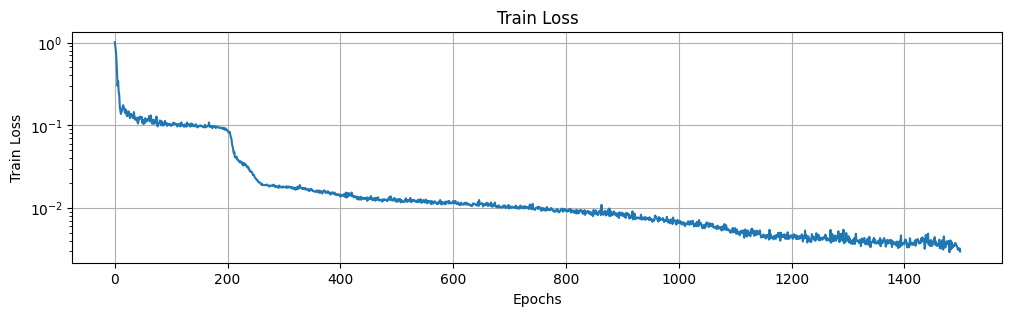

In [16]:
# Train the dynamics model
LATENT_DIM = 16
NUM_CHANNELS = 1
BETA = 0.0001
# BETA = 0.001
LR = 0.001
# LR = 0.0001
NUM_EPOCHS = 1500

vae_model = StateVAE(latent_dim=LATENT_DIM, num_channels=NUM_CHANNELS)
loss_func = VAELoss(beta=BETA)
optimizer = optim.Adam(vae_model.parameters(), lr=LR)

train_loader, val_loader, normalization_constants = process_data_multiple_step(collected_data[0:1], num_steps=1) # Single step data

# leekt
vae_model.train()

pbar = tqdm(range(NUM_EPOCHS))
train_losses = []
for epoch_i in pbar:
    train_loss_i = 0.
    # TODO: You should implement the training step. You need to call the encoder and the decoder a
    # --- Your code here
    for batch_idx, sample in enumerate(train_loader):
      # print("batch_idx = ", batch_idx)
      states = sample["states"]
      reconstructed_states, mu, log_var, latent_state = vae_model(states)

      optimizer.zero_grad()
      loss = loss_func(reconstructed_states, states, mu, log_var)
      # print("loss = ", loss)
      loss.backward()
      optimizer.step()

      train_loss_i = loss.item()


    # ---
    pbar.set_description(f'Train Loss: {train_loss_i:.4f}')
    train_losses.append(train_loss_i)

# plot train loss and test loss:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes = [axes]
axes[0].plot(train_losses)
axes[0].grid()
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')
axes[0].set_yscale('log')



Text(0.5, 1.0, 'Reconstructed State')

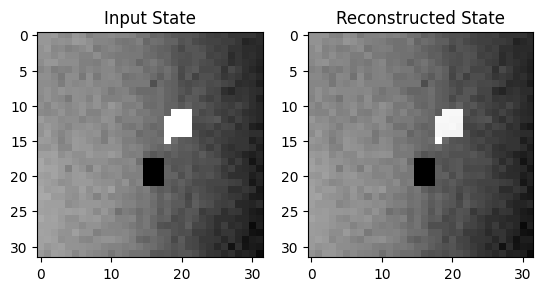

In [17]:
# Visualize the state and its reconstruction:
vae_model.eval()
batches = [b for b in val_loader]
norm_tr = NormalizationTransform(norm_constants)
state = batches[0]['states'][0,0]
z, log_var = vae_model.encoder(state)
state_rec = vae_model.decoder(z)
state_img = norm_tr.denormalize_state(state).detach().cpu().numpy().transpose(1,2,0).astype(np.uint8)
state_rec_img = norm_tr.denormalize_state(state_rec).detach().cpu().numpy().transpose(1,2,0).astype(np.uint8)

fig, axes = plt.subplots(1,2)
axes[0].imshow(state_img, cmap='gray')
axes[0].set_title('Input State')
axes[1].imshow(state_rec_img, cmap='gray')
axes[1].set_title('Reconstructed State')

If everything is fine, you should obtain a near-perfect reconstruction since the network has been able to memorize the single state.

## 3.2 - VAE Training  (20 points)

Next, once you know that your VAE implementation is working, you will have to train it on the full set of data.

mean =  tensor([180.6437])
std =  tensor([17.0322])


Latent dim 16 - Loss: 0.1355: 100%|██████████| 500/500 [04:04<00:00,  2.05it/s]


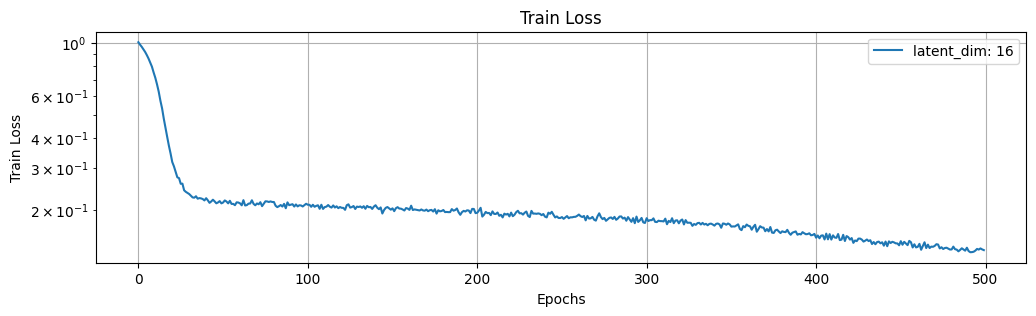

In [18]:
# Train the VAE

LR = 0.0001
NUM_EPOCHS = 500
# NUM_EPOCHS = 2000
BETA = 0.001
LATENT_DIM = 10
NUM_CHANNELS = 1
NUM_STEPS = 1
LATENT_DIM = 16

train_loader, val_loader, norm_constants = process_data_multiple_step(collected_data, num_steps=1)
norm_tr = NormalizationTransform(norm_constants)

all_states = []
for batch_i in train_loader:
    state_i = batch_i['states']
    all_states.append(state_i)
all_states = torch.cat(all_states, axis=0)

states = all_states.flatten(end_dim=1) # Get initial states (Num satates, num_channels, w, h)


vae_model = StateVAE(latent_dim=LATENT_DIM, num_channels=1)
loss_func = VAELoss(beta=BETA)
optimizer = optim.Adam(vae_model.parameters(), lr=LR)
pbar = tqdm(range(NUM_EPOCHS))
train_losses = []
for epoch_i in pbar:
    train_loss_i = 0.
    # --- Your code here
    for batch_idx, sample in enumerate(train_loader):
      # print("batch_idx = ", batch_idx)
      states_batch = sample["states"]
      reconstructed_states, mu, log_var, latent_state = vae_model(states_batch)

      optimizer.zero_grad()
      loss = loss_func(reconstructed_states, states_batch, mu, log_var)
      # print("loss = ", loss)
      loss.backward()
      optimizer.step()

      # train_loss_i = loss.item()


    # ---
    train_loss_i += loss.item()
    pbar.set_description(f'Latent dim {LATENT_DIM} - Loss: {train_loss_i:.4f}')
    train_losses.append(train_loss_i)

losses = train_losses
vaes = vae_model
# Evaluate:
vae_model.eval()
states_rec, mu, log_var, latent_state = vae_model(states)


# plot train loss and test loss:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes = [axes]
axes[0].plot(losses, label=f'latent_dim: {LATENT_DIM}')
axes[0].grid()
axes[0].legend()
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')
axes[0].set_yscale('log')


# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'vae_model.pt')
torch.save(vae_model.state_dict(), save_path)

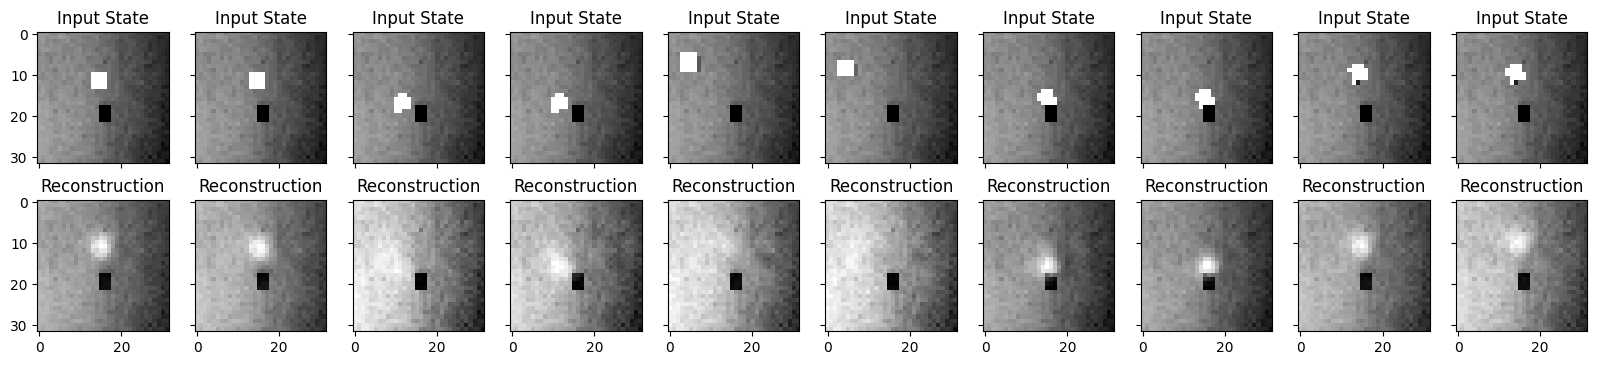

In [19]:
# Visualize the state and its reconstruction:
num_states_to_plot = 10
fig, axes = plt.subplots(2, num_states_to_plot, sharex=True, sharey=True, figsize=(2*num_states_to_plot, 4))
axes = np.transpose(axes)
for s_i in range(num_states_to_plot):
    state_i = states[s_i]
    # leekt debug
    # print("state_i.shape = ", state_i.shape)
    # test_state_img = norm_tr.denormalize_state(state_i).detach().cpu().numpy().astype(np.uint8)
    # print("test_state_img.shape = ", test_state_img.shape)

    state_img = norm_tr.denormalize_state(state_i).detach().cpu().numpy().transpose(1,2,0).astype(np.uint8)
    axes[s_i][0].imshow(state_img, cmap='gray')
    axes[s_i][0].set_title('Input State')
    state_rec_i = states_rec[s_i]
    state_rec_img = norm_tr.denormalize_state(state_rec_i).detach().cpu().numpy().transpose(1,2,0).astype(np.uint8)
    axes[s_i][1].imshow(state_rec_img, cmap='gray')
    axes[s_i][1].set_title(f'Reconstruction')

## Test performance

**GRADING GUIDE**: We will evaluate your vae model performance on the `pushing_image_validation_data`. You should obtain a loss of 0.2 or lower.

In [20]:
test_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_image_validation_data.npy'), allow_pickle=True)
norm_tr = NormalizationTransform(norm_constants)

single_step_dataset = MultiStepDynamicsDataset(test_data, num_steps=1, transform=norm_tr)
single_step_loader = DataLoader(single_step_dataset, batch_size=len(single_step_dataset))

loss_func = VAELoss(beta=BETA)

def test_vae(model, val_loader, loss_fn) -> float:
    """
    Perfoms an epoch of model performance validation
    :param model: Pytorch nn.Module
    :param train_loader: Pytorch DataLoader
    :param loss: Loss function
    :return: val_loss <float> representing the average loss among the different mini-batches
    """
    val_loss = 0. # TODO: Modify the value
    # Initialize the validation loop
    model.eval()
    for batch in val_loader:
        loss = None
        states = batch['states'].flatten(end_dim=1)
        states_rec, mu, log_var, latent_state = vae_model.forward(states)
        loss = loss_func(states_rec, states, mu, log_var)
        val_loss += loss.item()
    return val_loss/len(val_loader)


print(f'VAE model VALIDATION loss: {test_vae(vae_model, single_step_loader, loss_func)}')


VAE model VALIDATION loss: 0.12908601760864258


# 4 -  Learn Latent Dynamics  (30 points)

Previously you implemented a VAE to reconstruct the images. In this section you will have to implement and train a dynamics model from images.

You will implemented an Autoencoder and learn dynamics in the latent space of that autoencoder. 
### Architecture

As you have seen in class, there exist more sophisticated approaches such as Embed to Control (E2C) which use VAEs to obtain the latent vectors. E2C imposes more structure on the latent which makes it less prone to create predictions out of distribution. However, E2C has extra complexity, requires larger data samples, and take more time to train. Hence, for simplification here we will simplify the model to an encoder-decoder.

The full architecture is shown below:

![latent_dynamics_architecture](https://drive.google.com/uc?export=view&id=1cfXQvphGVWxeygowyXMtI63TkGEcCepN)

The model components are as follows:

First, you will have to implement a state encoder, which maps images into latent vectors. The desired architecture is very similar to the VAE encoder you implemented in the previosu question, but is now deterministic. The architecture is as follows:

![state_encoder_architecture](https://drive.google.com/uc?export=view&id=1zsECGD0SPXXfeYY-sx5X8wJcVk-HhiKe)

Next, you will have the dynamics model in the latent space. You should use exactly the same residual dynamics architecture you have used in both HW3 and HW4 for this. 

Finally there is the decoder. For the decoder we will use the decoder class you implemented for the VAE. 


### Loss Function

We will use a multi-step loss function to train the autoencoder and the latent dynamics model end-to-end. A single training trajectory is given by a sequence of images $x_0, x_1, ..., x_T$, and controls $a_0, ..., a_{T-1}$. We encoder **every** image to a latent vector $z$ with the encoder to produce $z_0, z_1, ..., z_T$. In other words, $z_{t} = \texttt{encode}(x_t)$.

From the initial latent state $z_0$ we apply the latent dynamics model **recursively**, i.e. $\hat{z}_{1} = f_{latent}(z_0, a_0)$, $\hat{z}_{2} = f_{latent}(\hat{z}_1, a_1)$ and so on. This produces predictions $\hat{z}_1, ..., \hat{z}_T$. Similarly, we do the same for states. Starting at $x_0$, we propagate state dynamics to produce $\hat{x}_1, ..., \hat{x}_T$, where $\hat{x}_{t+1} = f_\text{dyn}(\hat{x}_t, a_t)$, and $\hat{x}_{1} = f_\text{dyn}(x_0, a_0)$.

The full loss is then:

$$
    \frac{1}{T+1}\sum^T_{t=0} ||x_t - \texttt{decode}(z_t)||^2 + \frac{1}{T}\sum_{t=1}^T ||x_t - \hat x_{t}||^2 + \frac{\alpha}{T} \sum^T_{t=1} ||z_t - \hat{z}_t||^2
$$

$\alpha$ is a hyperparameter and should be set to 0.1. This loss term has three components, the first is a standard reconstruction loss. The second two losses are both losses on the latent dynamics prediction. 

**TODO:**
* Implement `StateEncoder` in `learning_latent_dynamics.py`
    * Need to implement `__init__` and `forward` methods
* Implement `LatentDynamicsModel` in `learning_latent_dynamics.py`
    * Need to implement the methods `__init__`, `forward`, `encode`, `decode` and `latent_dynamics`.
* Implement `MultiStepLoss` in `learning_latent_dynamics.py`
    * Need to implement the `forward`.
    * Your MultiStepLoss should work for arbitrary `num_steps` in the dataset, including `num_steps=1`, i.e. a single-step loss.
    
    

## 4.1 - Learn Single Step Latent Dynamics  (15 points)

First you will train the model with a single-step loss. This is acheived by simply passing `num_steps=1` into `process_data_multiple_step`. 

You should be able to train the model to have validation loss of <0.25. You will need to submit your model `single_step_latent_dynamics_model.pt` to autograder. 

mean =  tensor([180.6437])
std =  tensor([17.0322])


Latent dim 16 - Loss: 0.1133: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]


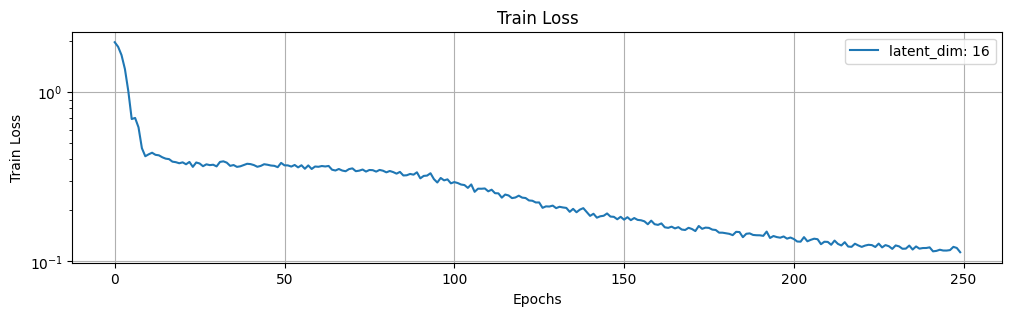

In [21]:
# Train the dynamics model

LATENT_DIM = 16
ACTION_DIM = 3
NUM_CHANNELS = 1
NUM_STEPS = 1

single_step_latent_dynamics_model = LatentDynamicsModel(latent_dim=LATENT_DIM, action_dim=ACTION_DIM, num_channels=NUM_CHANNELS)


# Compute normalization constants
train_loader, val_loader, norm_constants = process_data_multiple_step(collected_data, batch_size=500, num_steps=NUM_STEPS)
norm_tr = NormalizationTransform(norm_constants)

state_loss_fn = nn.MSELoss()
latent_loss_fn = nn.MSELoss()
multistep_loss = MultiStepLoss(state_loss_fn, latent_loss_fn, alpha=0.1)

# TODO: Train latent_dynamics_model
# --- Your code here
NUM_EPOCHS = 250
LR = 0.7 * 1e-3


optimizer = optim.Adam(single_step_latent_dynamics_model.parameters(), lr=LR)
pbar = tqdm(range(NUM_EPOCHS))
train_losses = []
for epoch_i in pbar:
    train_loss_i = 0.
    # --- Your code here
    for batch_idx, sample in enumerate(train_loader):
      # print("batch_idx = ", batch_idx)
      states_batch, actions_batch = sample["states"], sample["actions"]

      optimizer.zero_grad()
      loss = multistep_loss(single_step_latent_dynamics_model, states_batch, actions_batch)
      loss.backward()
      optimizer.step()
      
    # ---
    train_loss_i += loss.item()
    pbar.set_description(f'Latent dim {LATENT_DIM} - Loss: {train_loss_i:.4f}')
    train_losses.append(train_loss_i)

losses = train_losses
# vaes = vae_model
# # Evaluate:
# vae_model.eval()
# states_rec, mu, log_var, latent_state = vae_model(states)


# plot train loss and test loss:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes = [axes]
axes[0].plot(losses, label=f'latent_dim: {LATENT_DIM}')
axes[0].grid()
axes[0].legend()
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')
axes[0].set_yscale('log')


# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'single_step_latent_dynamics_model.pt')
torch.save(single_step_latent_dynamics_model.state_dict(), save_path)

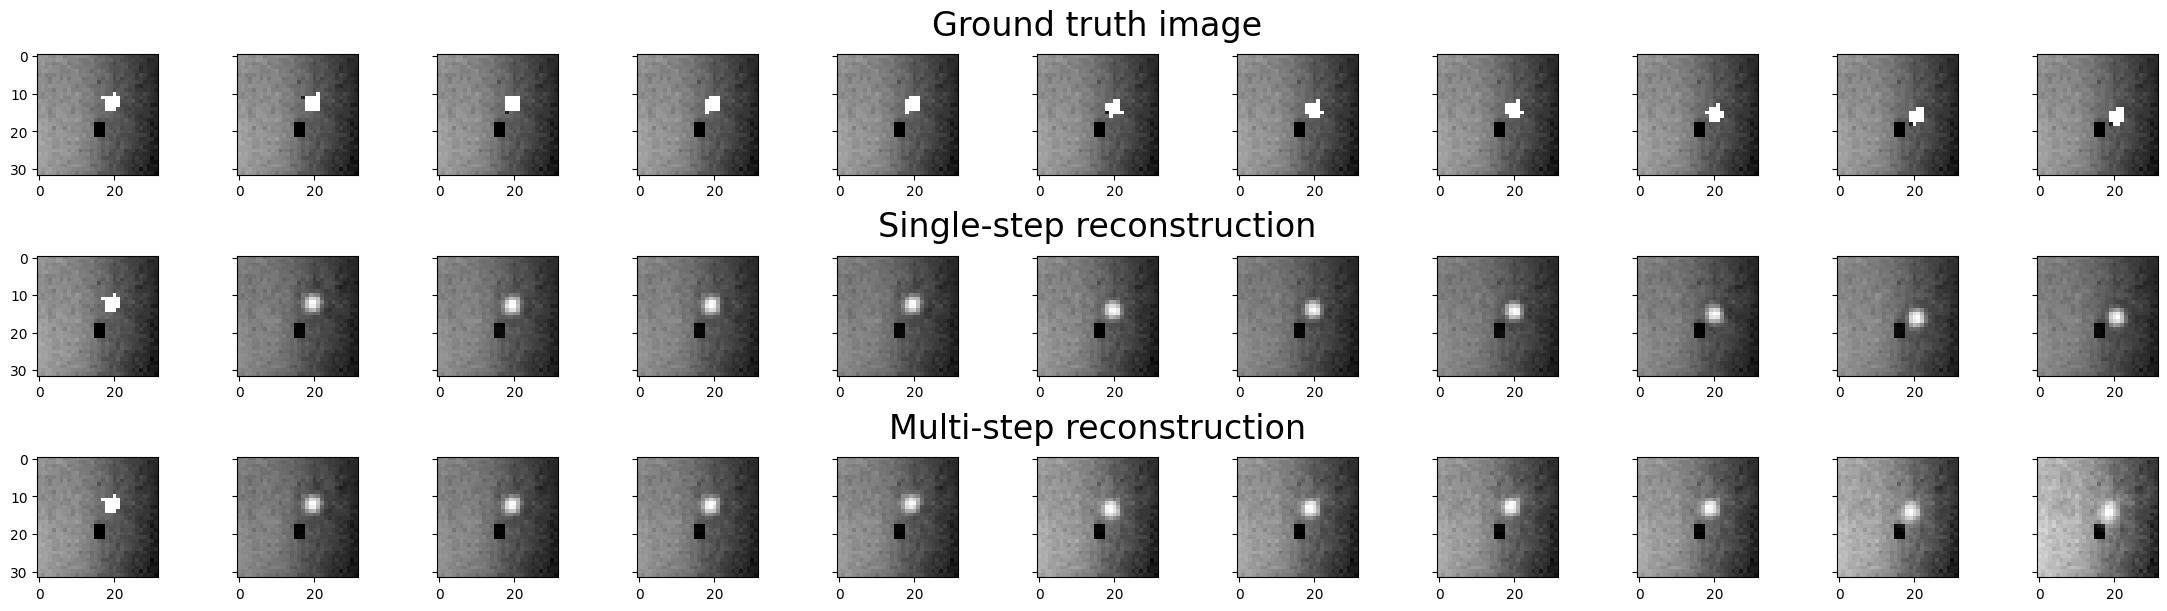

In [22]:
# Visualize the ability to perform single-step and multi-step state prediction:
traj = collected_data[0]
evaluate_model_plot(single_step_latent_dynamics_model, traj, norm_tr)

## 4.2 - Learn Multi-Step Dynamics  (15 points)

Now we will train using a multi-step loss by `num_steps=4` into `process_data_multiple_step`. 

You should be able to train the model to have validation loss of <0.25. You will need to submit your model `multi_step_latent_dynamics_model.pt` to autograder. 


In [ ]:
# Train the dynamics model
LATENT_DIM = 16
ACTION_DIM = 3
NUM_CHANNELS = 1
NUM_STEPS = 4

multi_step_latent_dynamics_model = LatentDynamicsModel(latent_dim=LATENT_DIM, action_dim=ACTION_DIM, num_channels=NUM_CHANNELS)

state_loss_fn = nn.MSELoss()
latent_loss_fn = nn.MSELoss()
multistep_loss = MultiStepLoss(state_loss_fn, latent_loss_fn, alpha=0.1)

# Compute normalization constants
train_loader, val_loader, norm_constants = process_data_multiple_step(collected_data, batch_size=512, num_steps=NUM_STEPS)


# --- Your code here
NUM_EPOCHS = 300
LR = 0.7 * 1e-3


optimizer = optim.Adam(multi_step_latent_dynamics_model.parameters(), lr=LR)
pbar = tqdm(range(NUM_EPOCHS))
train_losses = []
for epoch_i in pbar:
    train_loss_i = 0.
    # --- Your code here
    for batch_idx, sample in enumerate(train_loader):
      # print("batch_idx = ", batch_idx)
      states_batch, actions_batch = sample["states"], sample["actions"]

      optimizer.zero_grad()
      loss = multistep_loss(multi_step_latent_dynamics_model, states_batch, actions_batch)
      loss.backward()
      optimizer.step()
      
    # ---
    train_loss_i += loss.item()
    pbar.set_description(f'Latent dim {LATENT_DIM} - Loss: {train_loss_i:.4f}')
    train_losses.append(train_loss_i)

losses = train_losses


# plot train loss and test loss:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes = [axes]
axes[0].plot(losses, label=f'latent_dim: {LATENT_DIM}')
axes[0].grid()
axes[0].legend()
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')
axes[0].set_yscale('log')


# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'multi_step_latent_dynamics_model.pt')
torch.save(multi_step_latent_dynamics_model.state_dict(), save_path)

mean =  tensor([180.6415])
std =  tensor([17.0344])


Latent dim 16 - Loss: 0.3306:  46%|████▋     | 139/300 [04:00<05:51,  2.18s/it]

In [ ]:
# Visualize the ability to perform  state and its reconstruction:
traj = collected_data[0]
evaluate_model_plot(multi_step_latent_dynamics_model, traj, norm_tr)

## Single-Step vs Multi-Step Loss

Now we will evalaute the difference between the multi-step model and the single-step model. You should see that the multi-step trained model has similar or better performance on the single-step loss but better performance on the multi-step loss.

**Grading Details**: We will test the performance of your model on `pushing_image_validation_data.npy`. You need to obtain at least the following loss values:
* Single-step model evaluated on single-step loss: 0.25
* Single-step model evaluated on multi-step loss: 0.37
* Multi-step model evaluated on single-step loss: 0.23
* Multi-step model evaluated on multi-step loss: 0.33

In [ ]:
test_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_image_validation_data.npy'), allow_pickle=True)
norm_tr = NormalizationTransform(norm_constants)

single_step_dataset = MultiStepDynamicsDataset(test_data, num_steps=1, transform=norm_tr)
single_step_loader = DataLoader(single_step_dataset, batch_size=len(single_step_dataset))

multi_step_dataset = MultiStepDynamicsDataset(test_data, num_steps=4, transform=norm_tr)
multi_step_loader = DataLoader(multi_step_dataset, batch_size=len(multi_step_dataset))

loss = MultiStepLoss(state_loss_fn, latent_loss_fn, alpha=1)

def test(model, val_loader, loss_fn) -> float:
    """
    Perfoms an epoch of model performance validation
    :param model: Pytorch nn.Module
    :param train_loader: Pytorch DataLoader
    :param loss: Loss function
    :return: val_loss <float> representing the average loss among the different mini-batches
    """
    val_loss = 0. # TODO: Modify the value
    # Initialize the validation loop
    model.eval()
    for batch in val_loader:
        loss = None
        states = batch['states']
        actions = batch['actions']
        loss = loss_fn(model, states, actions)
        val_loss += loss.item()
    return val_loss/len(val_loader)


print(f'Single-step model evaluated on single-step loss: {test(single_step_latent_dynamics_model, single_step_loader, loss)}')
print(f'Single-step model evaluated on multi-step loss: {test(single_step_latent_dynamics_model, multi_step_loader, loss)}')
print('')
print(f'Multi-step model evaluated on single-step loss: {test(multi_step_latent_dynamics_model, single_step_loader, loss)}')
print(f'Multi-step model evaluated on multi-step loss: {test(multi_step_latent_dynamics_model, multi_step_loader, loss)}')


# 5 - Latent Space Control (MPPI)  (30 points)

For this last part, we will use the learned model to drive the block to a goal location from image states using your latent dynamics model.

In [ ]:
# Load the model
latent_dynamics_model = LatentDynamicsModel(latent_dim=LATENT_DIM, action_dim=ACTION_DIM, num_channels=NUM_CHANNELS)
model_path = os.path.join(GOOGLE_DRIVE_PATH, 'multi_step_latent_dynamics_model.pt')
latent_dynamics_model.load_state_dict(torch.load(model_path))

## 5.1 Latent Space Controller (15 points)

In this part we will use the learned latent dynamics model to formulate a control problem in latent space.

MPPI will propagate the dyanamics in the latent space. Moreover, the cost function will be formulated in latent space, comparing how close states are to the goal in latent space.

**TODO**:
* Implement `latent_space_pushing_cost_function` in `learning_latent_dynamics.py`.
* Implement the missing parts from `PushingLatentController` in `learning_latent_dynamics.py`. In particular you need to implement the following methods:
    * `_compute_dynamics`
    * `_compute_costs`
    * `control`
    * `_wrap_state`
    * `_unwrap_state`
    
**GRADING GUIDE**:
We will execute your controller 10 times starting from the configuration shown below.  At least one execution needs to reach the goal. We consider that the object has reached the goal if the distance to the goal is less than the size of the object, i.e. `goal_distance < BOX_SIZE`.

In [ ]:
import torch
a = torch.tensor([[1.0, 2.0, 3.0]])
b = torch.zeros_like(a)
print(a, b)
import torch.nn as nn
mse_loss = nn.MSELoss()
loss = mse_loss(a, b)
print(loss)
loss_n2 = torch.sum(torch.square(a - b))
print(loss_n2 / 3.0)

In [ ]:
# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)


target_state = np.array([0.7, 0., 0.])

env = PandaImageSpacePushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5, grayscale=True)
state_0 = env.reset()
env.object_target_pose = env._planar_pose_to_world_pose(target_state)
controller = PushingLatentController(env, latent_dynamics_model, latent_space_pushing_cost_function,norm_constants, num_samples=100, horizon=10)

state = state_0

# num_steps_max = 100
num_steps_max = 20

for i in range(num_steps_max):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    # check if we have reached the goal
    end_pose = env.get_object_pos_planar()
    goal_distance = np.linalg.norm(end_pose[:2]-target_state[:2]) # evaluate only position, not orientation
    goal_reached = goal_distance < BOX_SIZE
    if done or goal_reached:
        break

print(f'GOAL REACHED: {goal_reached}')
        
plt.close(fig)

## 5.2 - Image Space Controller (15 points)

In this final part, we will reformulate the controller to work in image space. MPPI will propagate the dynamics in image space and the costs will also be computed in the image space. We will use $\text{MSE}(\mathrm x_t, \mathrm x_g)$ to compute how close a state $\mathbf x_t$ is from the goal state $\mathrm x_g$.

**TODO**:
* Implement `img_space_pushing_cost_function` in `learning_latent_dynamics.py`.
* Implement the missing part from `PushingImgSpaceController` in `learning_latent_dynamics.py`. In particular you need to implement the following methods:
    * `_compute_dynamics`
    * `_compute_costs`
    * `control`
    * `_wrap_state`
    * `_unwrap_state`
    
**GRADING GUIDE**:
We will execute your controller 10 times on the configuration shown below.  At least one execution needs to reach the goal. We consider that the object has reached the goal if the distance to the goal is less than the size of the object, i.e. `goal_distance < BOX_SIZE`.

In [ ]:
a = torch.rand(3, 3)
all_but_last_three_dim = a.shape[:-3]
print(all_but_last_three_dim)

In [ ]:
# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)


target_state = np.array([0.7, 0., 0.])

env = PandaImageSpacePushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5, grayscale=True)
state_0 = env.reset()
env.object_target_pose = env._planar_pose_to_world_pose(target_state)
controller = PushingImgSpaceController(env, latent_dynamics_model, img_space_pushing_cost_function, norm_constants, num_samples=100, horizon=10)

state = state_0

# num_steps_max = 100
num_steps_max = 30


goal_reached = False
for i in range(num_steps_max):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    
    # check if we have reached the goal
    end_pose = env.get_object_pos_planar()
    goal_distance = np.linalg.norm(end_pose[:2]-target_state[:2]) # evaluate only position, not orientation
    goal_reached = goal_distance < BOX_SIZE
    if done or goal_reached:
        break


print(f'GOAL REACHED: {goal_reached}')
        
        
plt.close(fig)

Congratulations, you have reached the end of this homework. Nice work! 
Please, submit all required files to [autograder.io](https://autograder.io)